# Lab 3 — Dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [9]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)

### Exercise 3.1

In [10]:
from collections import OrderedDict
tag_to_movies_relevances = scores.map(lambda j: (j['tagId'], (j['movieId'], j['relevance'])))\
                                 .groupByKey()\
                                 .mapValues(lambda ls: list(ls))\
                                 .sortByKey()\
                                 .cache()

#### Exploring the scores data

In [11]:
seqOp = lambda accTup, entry: (min(accTup[0], len(entry[1])), max(accTup[0], len(entry[1])))
combOp = lambda tup1, tup2: (min(tup1[0], tup2[0]), max(tup1[1], tup2[1]))
minV, maxV = tag_to_movies_relevances.aggregate((movies.count(), 0), seqOp, combOp)
minV == maxV

True

We checked that all the tags are associated to the same number of movies. As the minimum number of movies per tag is equal to the maximum, each movie has a relevance for every tag: the data is not sparse (we did not consider movies without tags)

In [12]:
sc.parallelize(list(range(1, tag_to_movies_relevances.count() + 1)))\
  .subtract(tag_to_movies_relevances.keys()).count()

0

We checked that the tag ids are sequential integers from $1$ to $max(tagId)$. Therefore we know how to retrieve a tag from the matrix: $tagId = rowNumber + 1$.

Let's build the matrix:

In [13]:
rows = tag_to_movies_relevances.map(lambda el: [c[1] for c in sorted(el[1], key=lambda t: t[0])])
M = np.matrix(rows.collect())

Remark that we collect a list of lists. We could use PySparks mllib.linalg to build Vectors and Matrices. However this module uses numpy arrays and matrices on a single machine, therefore this makes no difference.

We compute the matrix $M$


In [14]:
M.shape

(1128, 10381)

In [15]:
tags.count()

1128

We have a $M \times N$ matrix where $M$ is the number of tags and $N$ is the number of movies

Let's center the matrix:

In [16]:
M = M - np.mean(M, axis=1)

#### Question A

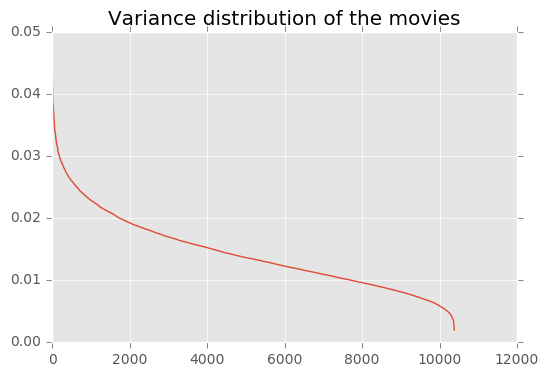

In [17]:
plt.plot(sorted(np.ravel(np.var(M, axis=0)), key=lambda x: -x))
plt.title('Variance distribution of the movies')

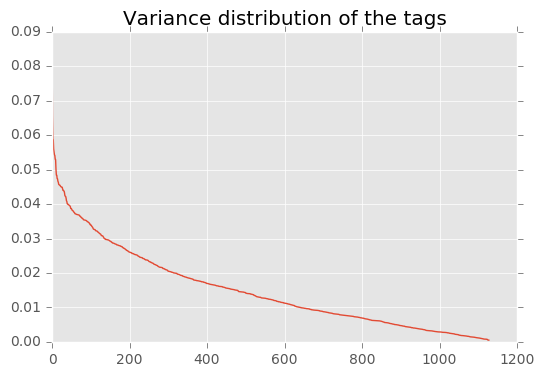

In [18]:
plt.plot(sorted(np.ravel(np.var(M, axis=1)), key=lambda x: -x))
plt.title('Variance distribution of the tags')

#### Question B

In [19]:
C = (M @ M.T) / M.shape[1]
C.shape

(1128, 1128)

In [20]:
sorted_values, vectors = la.eigh(C)
# Sort the eigenvalues (and therefore the vectors) by non increasing ordered
sorted_values = sorted_values[::-1]
vectors = np.fliplr(vectors)

In [21]:
sorted_values

array([  2.75311225e+00,   1.22135338e+00,   9.95955570e-01, ...,
         1.21306102e-04,   7.85861162e-05,   5.48978745e-05])

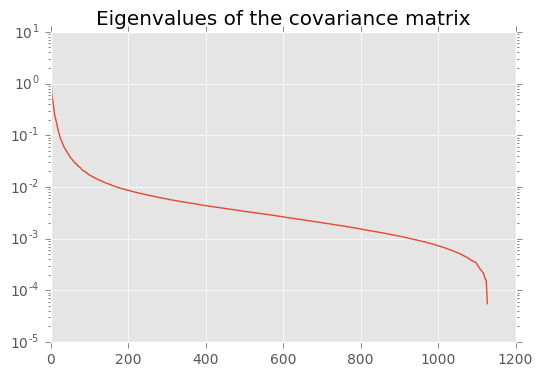

In [22]:
plt.semilogy(sorted_values)
plt.title('Eigenvalues of the covariance matrix')

#### Question C

We can see that eigenvalues fall off very quickly at the beginning. This means that a few directions can explain most of the data.

#### Conclusion

In [23]:
def directions_variability(ww, ratio):
    currentRatio = 0.0
    i = 1
    tot = np.sum(ww)
    while currentRatio < ratio:
        currentRatio = np.sum(ww[:i]) / tot
        i += 1
    return i - 1

In [24]:
print('We need', directions_variability(sorted_values, 2/3), 'directions to explain 2/3 of the variability in the data')

We need 37 directions to explain 2/3 of the variability in the data


### Exercise 3.2

#### Setup

In [25]:
DIRECTIONS = 5

In [26]:
top5values = sorted_values[:DIRECTIONS]
top5vectors = vectors[:,:DIRECTIONS]

In [27]:
top5vectors.shape

(1128, 5)

In [28]:
tag_to_name = dict(tags.map(itemgetter("tagId", "tag")).collect())

In [29]:
dir_to_best = {}
dir_to_worst = {}
for direction in range(DIRECTIONS):
    ordered = sorted([(idx, top5vectors[idx, direction]) for idx in range(1128)], key=lambda t: -t[1])
    
    best10 = [tag_to_name[el[0] + 1] for el in ordered[:10]]
    worst10 = [tag_to_name[el[0] + 1] for el in ordered[::-1][:10]]
    dir_to_best[direction] = best10  
    dir_to_worst[direction] = worst10

In [30]:
dir_to_best

{0: ['talky',
  'social commentary',
  'criterion',
  'imdb top 250',
  'great acting',
  'drama',
  'oscar (best directing)',
  'bleak',
  'dramatic',
  'cinematography'],
 1: ['intimate',
  'relationships',
  'criterion',
  'melancholic',
  'loneliness',
  'golden palm',
  'meditative',
  'art house',
  'melancholy',
  'sexual'],
 2: ['feel-good',
  'sentimental',
  'love story',
  'heartwarming',
  'touching',
  'romantic',
  'sweet',
  'courage',
  'girlie movie',
  'feel good movie'],
 3: ['visual',
  'visually stunning',
  'imagination',
  'sci-fi',
  'scifi',
  'visually appealing',
  'science fiction',
  'sci fi',
  'special effects',
  'beautifully filmed'],
 4: ['thriller',
  'conspiracy',
  'secrets',
  'suspenseful',
  'tense',
  'mystery',
  'suspense',
  'investigation',
  'murder mystery',
  'betrayal']}

In [31]:
dir_to_worst

{0: ['predictable',
  "so bad it's funny",
  'bad plot',
  'silly',
  'silly fun',
  'horrible',
  'franchise',
  'lame',
  'big budget',
  'comedy'],
 1: ['action',
  'special effects',
  'big budget',
  'chase',
  'fast paced',
  'suspense',
  'good action',
  'plot',
  'pg-13',
  'action packed'],
 2: ['horror',
  'weird',
  'creepy',
  'splatter',
  'stylish',
  'cult classic',
  'disturbing',
  'violence',
  'cult film',
  'dark'],
 3: ['corruption',
  'crime',
  'murder',
  'police investigation',
  'thriller',
  'suspense',
  'violence',
  'police corruption',
  'gangsters',
  'manipulation'],
 4: ['comedy',
  'funny',
  'hilarious',
  'goofy',
  'humorous',
  'humor',
  'very funny',
  'cult classic',
  'quotable',
  'funny as hell']}

Looking at the tags with highest and lowest coordinates in the first 5 five directions, we find the following concepts to descripe each principal component : 
- 0: good movie/bad movie
- 1: deep/blockbuster (action based)
- 2: sweet/horror
- 3: good looking/good plot
- 4: suspenseful/comedy

#### Writing file to disk

In [32]:
tag_to_coordinates = {}
for tag in range(1128):
    coords = []
    for direction in range(DIRECTIONS):
        coords.append(top5vectors[tag, direction])
    tag_to_coordinates[tag_to_name[tag + 1]] = coords

jsonarray = json.dumps(tag_to_coordinates, ensure_ascii=False)

with open('data.txt', 'w') as dst:
    json.dump(jsonarray, dst)

### Exercise 3.3

In [33]:
import pickle

In [35]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
movies = sorted(movies, key=lambda x: x[0])
movies_to_ids = [movie[0] for movie in movies]

In [36]:
movies[:4]

[(260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (356, 'Forrest Gump (1994)', 0.72),
 (480, 'Jurassic Park (1993)', 0.93)]

#### Question A

In [37]:
new_matrix_rows = scores.map(itemgetter('movieId', 'relevance'))\
                        .filter(lambda x: x[0] in moviesIds)\
                        .groupByKey()\
                        .sortByKey()\
                        .map(lambda x: list(x[1]))\
                        .collect()

In [39]:
new_matrix = np.matrix(new_matrix_rows)
new_matrix.shape

(37, 1128)

In [40]:
new_values = sorted_values[:2]
new_vectors = vectors[:,:2]

In [41]:
projected_matrix = (new_matrix @ new_vectors).tolist()

In [42]:
projected_matrix

[[5.2832496543578324, -7.576582963071961],
 [8.263266304963055, -5.846979358682076],
 [6.080402888934187, -5.029462539700734],
 [3.4670611846015627, -7.283029689024394],
 [8.012862850827643, -4.795991450586858],
 [1.9563192464706614, -7.004651322298655],
 [3.755509495583608, -3.8082300471480055],
 [6.34224322689365, -3.2403711678747174],
 [4.887597829601472, -7.444349465494821],
 [6.60835290283577, -3.535904261552043],
 [8.407282228254967, -4.879104796308239],
 [6.166922994976304, -8.28875686934102],
 [2.2125037350328154, -3.6432593003081424],
 [8.594701228394449, -3.1185938681355125],
 [8.44873288967171, -5.661292452125196],
 [5.112584895129661, -2.2201140873897733],
 [5.7849314280172175, -3.482605027518495],
 [5.478011932785149, -1.8601570872829674],
 [0.7511985315999727, -2.300994940111544],
 [7.467585235072499, -1.0961272811702452],
 [4.417500015444921, -2.82659672751574],
 [2.423473011939735, -6.568361706153171],
 [2.558724956197574, 0.21770525613205594],
 [8.862855699951105, -4.3

In [43]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [44]:
# Categorial colors
from bokeh.palettes import Dark2_8
from matplotlib.colors import rgb2hex 

cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]
    
source = ColumnDataSource(
    data={
        "x": [x[0] for x in projected_matrix],
        "y": [x[1] for x in projected_matrix],
        "name": [x for x in movies],
        "color": [val2rgb(x[2]) for x in movies],
    })

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

#### Question B

Recall:

 - Component 0: good movie/bad movie
 - Component 1: deep/blockbuster (action based)

Knowing the general concepts described by the first two dimensions, we can confirm that our plot for the selected movies makes perfect sense. Indeed:

 - Looking at the top right corner in our plot, we find the movie Wild Strawberries which has a score of 0.95 on rotten tomatoes and is qualified by wikipedia as a "moving film". This corresponds to our description of the first two principal directions.
 - Looking the bottom right, we find the movie Matrix which has a score of 0.87 on rotten tomatoes and can be seen as a blockbuster (63 million dollars budget accordint to wikipedia)
 - Looking at the top left, we find the movie Just my Luck which as a low score of 0.13 on rotten tomatoes and can be characterized as a more emotion focused movie than Matrix or Battleship
 - Looking at the bottom left, we find the movie Battleship which as a low score of 0.34 on rotten tomatoes and a budget of 209–220 million dollars according to wikipedia.

#### Question C

In [46]:
#Projecting on first principal component

hover2 = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools2 = [hover2, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

source2 = ColumnDataSource(
    data={
        "x": [x[0] for x in projected_matrix],
        "y": [0 for x in projected_matrix],
        "name": [x for x in movies],
        "color": [val2rgb(x[2]) for x in movies],
    })

p = figure(plot_width=960, plot_height=360, tools=tools2, title="Mouse over the dots")
p.circle("x", "y", source=source2, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

By projecting the data points on the first axis, we can see that there is quite a strong correlation between the rotten tomato score and the coordinate of the point in that direction. As for the second principal direction, we can see on the plot below that is not really correlated to the rotten tomato score.

In [48]:
source3 = ColumnDataSource(
    data={
        "x": [0 for x in projected_matrix],
        "y": [x[1] for x in projected_matrix],
        "name": [x for x in movies],
        "color": [val2rgb(x[2]) for x in movies],
    })

hover3 = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools3 = [hover3, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools3, title="Mouse over the dots")
p.circle("x", "y", source=source3, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)